### Project Description:

For a startup that sells food products, there is a need to investigate user behavior for the company's app:
   * First study the sales funnel:
        * How do users reach the purchase stage?
        * How many users actually make it to this stage?
        * How many get stuck at previous stages? 
        * Which stages in particular?
    * Second: The designers would like to change the fonts for the entire app. the managers are afraid the users might find the new design intimidating. They decide to make a decision based on the results of an A/A/B test. The users are split into three groups: two control groups get the old fonts and one test group gets the new ones.
        * Which set of fonts produces better results?
        * Creating two A groups has certain advantages. 
        * We can make it a principle that we will only be confident in the accuracy of our testing when the two control groups are similar. 
       * If there are significant differences between the A groups, this can help us uncover factors that may be distorting the results. 
       * Comparing control groups also tells us how much time and data we'll need when running further tests.

we'll be using the same dataset for general analytics and for A/A/B analysis. In real projects, experiments are constantly being conducted. 
Analysts study the quality of an app using general data, without paying attention to whether users are participating in experiments.

### Table of contents:
1. [Description of the data](#Description-of-the-data:)


2. [Open the data file and read the general information:](#Step-1.-Open-the-data-file-and-read-the-general-information:)


3. [Prepare the data for analysis:](#Step-2.-Prepare-the-data-for-analysis:)


4. [Study and check the data](#Step-3.-Study-and-check-the-data:)

    4.1 [How many events are in the logs? How many users are in the logs? What's the average number of events per user?](#number-of-logs,-number-of-users:)
    
    4.2 [Excluding the older data, and make sure nothing important got lost:](#Excluding-the-older-data,-and-make-sure-nothing-important-got-lost:)
    
    
5. [Study the event funnel and number of users who performed each of the actions:](#Step-4.-Study-the-event-funnel:)

    5.1 [frequency of occurrence:](#frequency-of-occurrence:)
    
    5.2 [funnel](#funnel:)
    
  
6. [Study the results of the experiment:](#Step-5.-Study-the-results-of-the-experiment:)

    6.1 [AA test](#in-the-following-steps-we-will-check-if-there-is-a-statistically-significant-difference-between-samples-246-and-247.)
    
    6.2 [Comparison between experiment 248 with each of the control groups for each event in isolation:](#Comparison-between--experiment-248-with-each-of-the-control-groups-for-each-event-in-isolation:)
    
    6.3 [Comparison between experiment 248 with the combination of the control groups for each event in isolation:](#Comparison-between--experiment-248-with-the-combination-of-the-control-groups-for-each-event-in-isolation:)
    
    6.4 [conclusion](#conclusion:)
    

### Description of the data:
Each log entry is a user action or an event:
* EventName — event name
* DeviceIDHash — unique user identifier
* EventTimestamp — event time
* ExpId — experiment numbers: 246 and 247 are the control groups, and 248 is the test group

### Step 1. Open the data file and read the general information:

In [1]:
# Loading the libraries
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from datetime import datetime
import plotly.express as px
from plotly import graph_objects as go
from statsmodels.stats.proportion import proportions_ztest

In [2]:
try:
    logs = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

except:
     logs = pd.read_csv('logs_exp_us.csv', sep='\t')

logs.sample(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
161918,OffersScreenAppear,4233162799441605888,1565015238,248
81569,MainScreenAppear,5696093535989664031,1564821202,248
105771,OffersScreenAppear,4019459067081772785,1564860610,246
76371,MainScreenAppear,8841768891130937973,1564807928,248
131035,MainScreenAppear,3041995274047263770,1564933849,247


In [3]:
# Change the timestamp into two different date and time columns:
date_time = pd.to_datetime(logs['EventTimestamp'], unit ='s')
logs['date'] = pd.to_datetime(date_time).dt.date
logs['time'] = pd.to_datetime(date_time).dt.time
logs.head(3)

,EventName,DeviceIDHash,EventTimestamp,ExpId,date,time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25,11:28:47


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
 4   date            244126 non-null  object
 5   time            244126 non-null  object
dtypes: int64(3), object(3)
memory usage: 11.2+ MB


### Step 2. Prepare the data for analysis:  

In [5]:
# Rename the columns:
logs.columns=['event_name','device_id','event_timestamp','exp_id', 'date', 'time']

In [6]:
# profile report does not work on platform, I just want u to see that I cheke  the data foe zeros and duplicates:
# using profile report to see if ther's any duplicate, zero's and what are the unique values:
# profile_logs = ProfileReport(logs)
# display(profile_logs)

**By profile report:**

* logs table has 5 columns and 244,126 rows.
* there are 355 duplicate rows, and there are rows that repeat 5 and 4 times. I'm going to drop the duplicates
* event_name has 5 distinct values: 
    * MainScreenAppear 119,205
    * OffersScreenAppear 46,825
    * CartScreenAppear 42,731
    * PaymentScreenSucces 34,313
    * Tutorial 1,052.
* exp_id has 3 distinct values:
    * 248 (test group): 85,747
    * 246 (control group): 80,304
    * 247 (control group): 78,075
* date_time: 25/07/2019 - 07/08/2019
* There are no missing values or zeroes. 


In [7]:
# Drop the duplicated rows:  
logs.drop_duplicates().reset_index(drop =True)

,event_name,device_id,event_timestamp,exp_id,date,time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25,11:48:42
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07,21:12:25
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07,21:13:59
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07,21:14:43
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07,21:14:58


### Step 3. Study and check the data:

#### number of logs, number of users: 

* There are 243,713 logs after cleaning the data. 
* Assuming each user logs in through a single device, by grouping device id and counting the timestamp, we can find out :
    * how many users are in the logs,
    * how many events per user.  

In [8]:
num_of_events = logs.groupby('device_id')['event_timestamp'].count().reset_index()
num_of_events.columns=['device_id', 'number of logs']
num_of_events.head(5)

,device_id,number of logs
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137


In [9]:
print('number of users:')
len(num_of_events)

number of users:


7551

In [19]:
# fig2 = px.box(num_of_events, y="number of logs", title = 'number of logs')
# fig2.show()

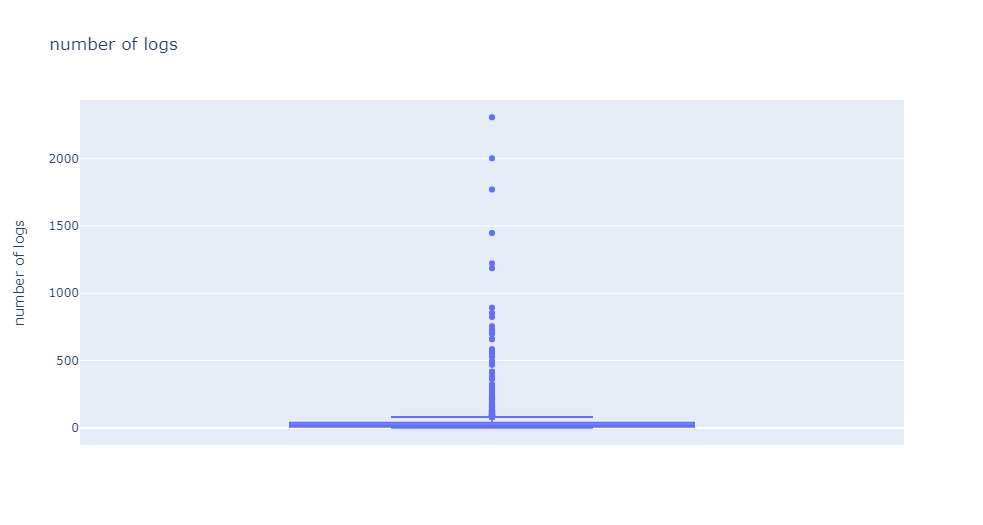

* In the graph above we can see that the majority of the users log into the system up to 100 times. 
* Its clear to see that the number of logs has a lot of outliers
* those results irrelevant to the test

In [11]:
print('the minimum number of events per user: ', num_of_events['number of logs'].min())
print('the average number of events per user: ', round(num_of_events['number of logs'].mean()))
print('the median number of events per user: ',num_of_events['number of logs'].median())
print('the maximum number of events per user ', num_of_events['number of logs'].max())

the minimum number of events per user:  1
the average number of events per user:  32
the median number of events per user:  20.0
the maximum number of events per user  2308


In [12]:
logs.sample(5)

,event_name,device_id,event_timestamp,exp_id,date,time
58668,MainScreenAppear,7727722930231941028,1564752928,246,2019-08-02,13:35:28
120066,PaymentScreenSuccessful,1469446514770057243,1564916437,246,2019-08-04,11:00:37
474,MainScreenAppear,6274455082583969109,1564478778,246,2019-07-30,09:26:18
81641,MainScreenAppear,1407232096472976945,1564821353,248,2019-08-03,08:35:53
147435,OffersScreenAppear,6377824737203294106,1564991985,246,2019-08-05,07:59:45


In [13]:
print('the earliest log date: ', logs['date'].min())
print('the latest log date: ', logs['date'].max())
print('the earliest log time: ', logs['time'].min())
print('the latest log time: ', logs['time'].max())

the earliest log date:  2019-07-25
the latest log date:  2019-08-07
the earliest log time:  00:00:00
the latest log time:  23:59:59


In [14]:
grp_date = logs.groupby('date')['event_timestamp'].count().reset_index()
grp_date.columns=['date','number of users']

In [17]:
# fig3 = px.histogram(logs, 
#                     x='date',
#                     title = 'Date histogram')
# fig3.update_layout(yaxis_title='Number of users', xaxis_title="Date",)
# fig3.show()


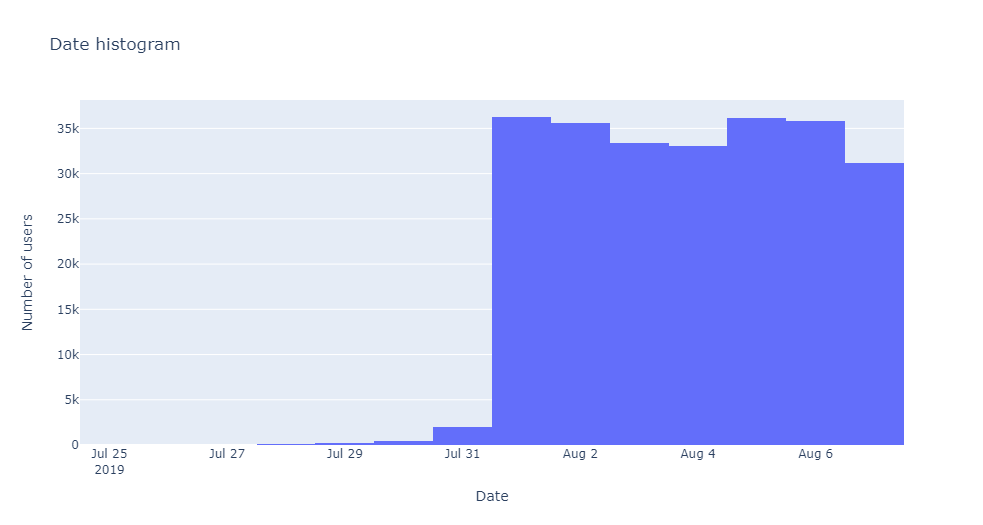

* By the graph above we can see that the user's logs are between July 25, to August 6. 
* From August 1,  there is a major leap from 5K to 36K. Maybe older events didn't end up for some users due to technical reasons.
* I'm going to consider only the data from August.  

In [18]:
# sort_log_by_time = logs.sort_values(by='time', ascending = True)
# fig4 = px.histogram(sort_log_by_time, 
#                     x='time',
#                     title = 'Time histogram')
# fig4.update_layout(yaxis_title='Number of users', xaxis_title="Time")
# fig4.show()


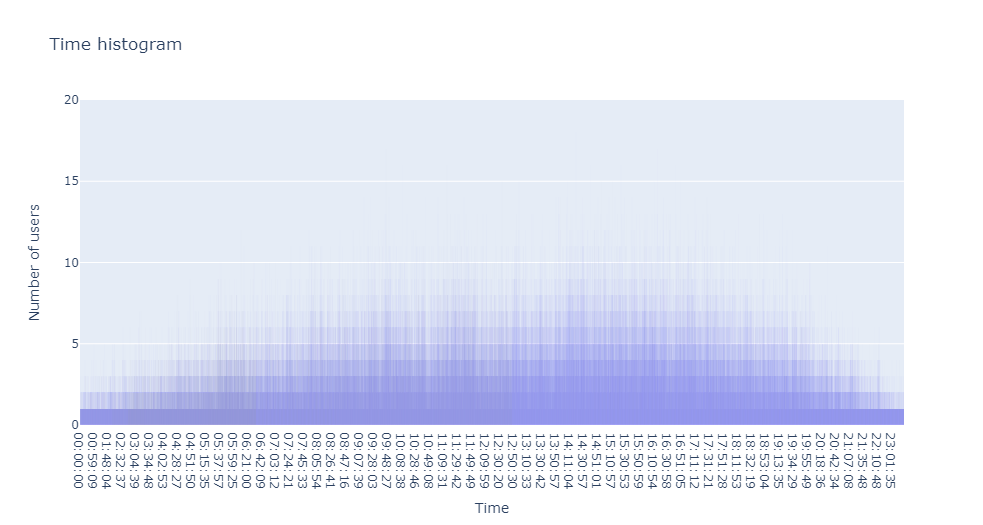

* By the graph above, we can see that most of the users logged in between 9:00 - 20:00 it makes sense. 

#### Excluding the older data, and make sure nothing important got lost:

In [21]:
# Let's check if we lose many events and users when excluding the older data,
# and Make sure we have users from all three experimental groups:
august_logs=logs.query('event_timestamp > 1564666847')
print("length of the dataset after exluding July logs:", len(august_logs))
num_of_events_august = august_logs.groupby('device_id')['event_timestamp'].count().reset_index()
print("number of the users after exluding July logs:", len(num_of_events_august))
print("number of logs for each trial after exluding July logs:")
print(august_logs['exp_id'].value_counts())

length of the dataset after exluding July logs: 222340
number of the users after exluding July logs: 7404
number of logs for each trial after exluding July logs:
248    78140
246    73412
247    70788
Name: exp_id, dtype: int64


### Step 4. Study the event funnel:

#### frequency of occurrence and number of times each action been  performed:

In [23]:
# grp_by_event = august_logs.groupby(['event_name','date'])['event_timestamp'].count().reset_index()
# grp_by_event.columns=['event_name', 'date', 'number of logs']
# fig5 = px.line(grp_by_event, x='date', y='number of logs', color='event_name', title = 'frequency of events occurrence')
# fig5.show()


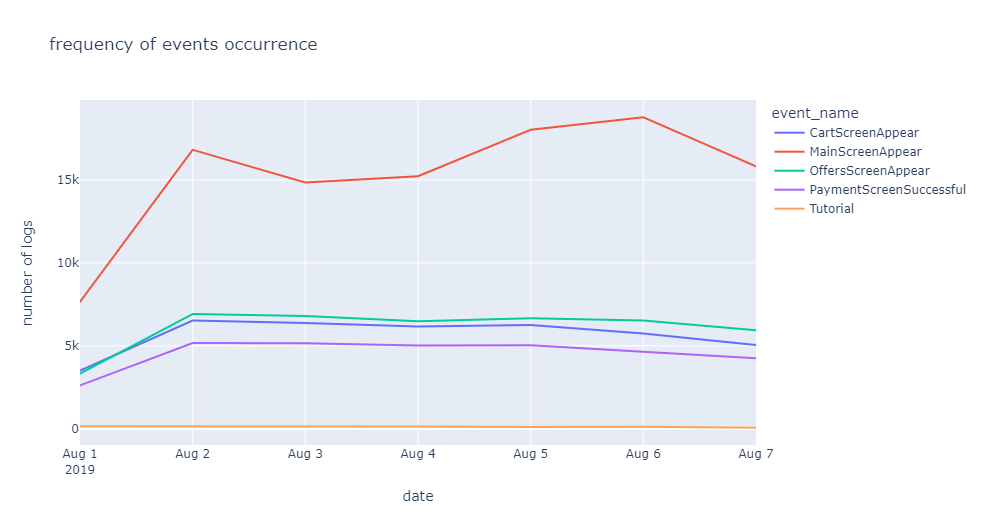

* By the graph above we can see:
    *  MainScreenAppear event is the most frequent, between 7.6K - 18.77K occurrences in one day
    * OfferScreenAppear event is the second, between 3.3K - 7K occurrences in one day
    * CartScreenAppear event is the third, between 3.3K - 6.5K occurrences in one day
    * PayentScreenSuccesful event is the forth, between 2.69K - 5.2K occurrences in one day
    * Tutorial event is the fifth, between 70 - 140 occurrences in one day

In [25]:
#The number of users who performed each actions:
num_of_user_each_action = august_logs.groupby('event_name')['device_id'].nunique().reset_index()
num_of_user_each_action.columns=['event_name', 'number users']
num_of_user_each_action.sort_values(by='number users', ascending = False)

,event_name,number users
1,MainScreenAppear,7282
2,OffersScreenAppear,4487
0,CartScreenAppear,3658
3,PaymentScreenSuccessful,3467
4,Tutorial,763


In [26]:
# The proportion of users who performed the action at least once:
num_of_user_each_action['proportion'] = num_of_user_each_action['number users']/len(num_of_events_august)
num_of_user_each_action.sort_values(by='proportion', ascending = False)

,event_name,number users,proportion
1,MainScreenAppear,7282,0.983522
2,OffersScreenAppear,4487,0.606024
0,CartScreenAppear,3658,0.494057
3,PaymentScreenSuccessful,3467,0.468260
4,Tutorial,763,0.103052


I believe the actions took place in the following order: 
* enter the website to MainScreen
* find products of interest and add that product to  the cart 
* CartScreenAppear
* PaymentScreenSuccessful	
    * I believe 'Tutorial' is not part of the relevant actions. 

#### Funnel:

In [28]:
# # funnel to find the share of users that proceed from each stage to the next:
# fig6 = go.Figure(go.Funnel(
#     y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear ", "PaymentScreenSuccessful"],
#     x = [7282, 4487, 3658, 3467, 763]))

# fig6.show()

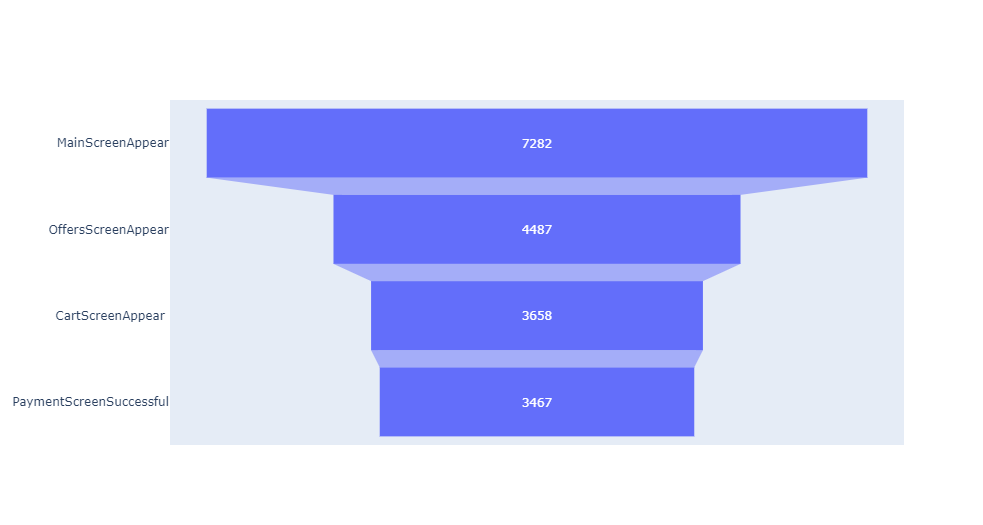

**By looking at the graph above we can see:** 
* 7282 users got into the main screen 
* 4487 users, 61%, move on to the offer screen 
* 3758 users, 50% , move on to the cart screen
* only 3467 users,  47.6%, carry on to the payment stage, all the rest got lost in the earlier stages
* we can see that most of the users got lost between the first and second stage

### Step 5. Study the results of the experiment: 

##### in the following steps we will check if there is a statistically significant difference between samples:
* 246 and 247,
* 246 and 248,
* 247 and 248,
* 246+247 and 248
* groups 246 and 247 are control groups and part of the A/A test, where we check our mechanisms and calculations,
* Group 248 represents the results of the A/B test.  

##### first find the number of users in each experiment:

In [29]:
# assigning the experimnt size for the relevent integer:
size_246 =  august_logs.query('exp_id==246')['device_id'].nunique()
size_247 =  august_logs.query('exp_id==247')['device_id'].nunique()
size_248 =  august_logs.query('exp_id==248')['device_id'].nunique()

**find the number of users in each step for every experiment:**

In [30]:
# find the number of users in each step for every experiment:
sample=august_logs.pivot_table(index = 'event_name',
                               columns= 'exp_id',
                               values = 'device_id',
                               aggfunc = 'nunique').reset_index()
sample = sample.sort_values(by=246, ascending = False)
# rename the columns and index for better orientation:

sample.index =['main','offers', 'cart','payment','tutorial']

sample



exp_id,event_name,246,247,248
main,MainScreenAppear,2407,2432,2443
offers,OffersScreenAppear,1514,1476,1497
cart,CartScreenAppear,1244,1213,1201
payment,PaymentScreenSuccessful,1177,1134,1156
tutorial,Tutorial,252,254,257


##### define a function to calculate P-value:

In [31]:
def is_differ(success1, success2, experiment1, experiment2, alpha):
    diff = ((success1/experiment1)-(success2/experiment2))
    stat, pval = proportions_ztest([success1, success2], 
                                  [experiment1, experiment2],
                                  diff)
    print ('p-value:', pval)
    if (pval < alpha):
        print('we reject the null hyp, we cant say the pages are the same')
    else :
        print ('we cant reject the null hyp, we goin to assume the pages are the same')

In [32]:
sample

exp_id,event_name,246,247,248
main,MainScreenAppear,2407,2432,2443
offers,OffersScreenAppear,1514,1476,1497
cart,CartScreenAppear,1244,1213,1201
payment,PaymentScreenSuccessful,1177,1134,1156
tutorial,Tutorial,252,254,257


#####  preforming Z test on experiments 246 and 247:

In [33]:

alpha = 0.05/4 # Bonferroni correction, we are goint to perform the tests 4 times
print ('The MainScreen for tests 246 and 247 :')
is_differ(sample.loc['main',246], sample.loc['main',247], size_246, size_247, alpha)
print()
print ('The OffersScreen for tests 246 and 247 :')
is_differ(sample.loc['offers',246], sample.loc['offers',247], size_246, size_247, alpha)
print()
print ('The CartScreen for tests 246 and 247 :')
is_differ(sample.loc['cart',246], sample.loc['cart',247], size_246, size_247, alpha)
print()
print ('The PaymentScreen for tests 246 and 247 :')
is_differ(sample.loc['payment',246], sample.loc['payment',247], size_246, size_247, alpha)

The MainScreen for tests 246 and 247 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same

The OffersScreen for tests 246 and 247 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same

The CartScreen for tests 246 and 247 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same

The PaymentScreen for tests 246 and 247 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same


**experiment 246 and experiment 248 have the same conversion rate for the pages, the groups do not differ, I assume they were split properly**

##### Comparison between  experiment 248 with each of the control groups for each event in isolation:

In [151]:
alpha = 0.05/12 #Bonferroni correction, we are goint to perform the test 8 times plus the 4 tests we preformed above. 
print ('The MainScreen for tests 246 and 248 :')
is_differ(sample.loc['main',246], sample.loc['main',248], size_246, size_248, alpha)
print()
print ('The OffersScreen for tests 246 and 248 :')
is_differ(sample.loc['offers',246], sample.loc['offers',248], size_246, size_248, alpha)
print()
print ('The CartScreen for tests 246 and 248 :')
is_differ(sample.loc['cart',246], sample.loc['cart',248], size_246, size_248, alpha)
print()
print ('The PaymentScreen for tests 246 and 248 :')
is_differ(sample.loc['payment',246], sample.loc['payment',248], size_246, size_248, alpha)

print ('The MainScreen for tests 248 and 247 :')
is_differ(sample.loc['main',248], sample.loc['main',247], size_248, size_247, alpha)
print()
print ('The OffersScreen for tests 248 and 247 :')
is_differ(sample.loc['offers',248], sample.loc['offers',247], size_248, size_247, alpha)
print()
print ('The CartScreen for tests 248 and 247 :')
is_differ(sample.loc['cart',248], sample.loc['cart',247], size_248, size_247, alpha)
print()
print ('The PaymentScreen for tests 248 and 247 :')
is_differ(sample.loc['payment',248], sample.loc['payment',247], size_248, size_247, alpha)

The MainScreen for tests 246 and 248 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same

The OffersScreen for tests 246 and 248 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same

The CartScreen for tests 246 and 248 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same

The PaymentScreen for tests 246 and 248 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same
The MainScreen for tests 248 and 247 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same

The OffersScreen for tests 248 and 247 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same

The CartScreen for tests 248 and 247 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same

The PaymentScreen for tests 248 and 247 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same


**both experiments 246 and 248 have the same conversion rate for the pages, 
and both experiments 247 and 248 have the same conversion rate for the pages**

##### Comparison between  experiment 248 with the combination of the control groups for each event in isolation:

In [152]:
alpha = 0.05/16 #Bonferroni correction, we are goint to perform the another 4 times plus the 12 tests we preformed above. 
print ('The MainScreen for tests 246+247 and 248 :')
is_differ(sample.loc['main',246]+sample.loc['main',247], sample.loc['main',248], size_246+size_247, size_248, alpha)
print()
print ('The OffersScreen for tests 246+247 and 248 :')
is_differ(sample.loc['offers',246]+sample.loc['offers',247], sample.loc['offers',248], size_246+size_247, size_248, alpha)
print()
print ('The CartScreen for tests 246+247 and 248 :')
is_differ(sample.loc['cart',246]+sample.loc['cart',247], sample.loc['cart',248], size_246+size_247, size_248, alpha)
print()
print ('The PaymentScreen for tests 246+247 and 248 :')
is_differ(sample.loc['payment',246]+sample.loc['payment',247], sample.loc['payment',248], size_246+size_247, size_248, alpha)

The MainScreen for tests 246+247 and 248 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same

The OffersScreen for tests 246+247 and 248 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same

The CartScreen for tests 246+247 and 248 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same

The PaymentScreen for tests 246+247 and 248 :
p-value: 1.0
we cant reject the null hyp, we goin to assume the pages are the same


We performed 16 tests on the same data. when we checked the hypothesis we set alpha to 0.05, which means there is a 5% chance that there is an error, and that we draw the wrong conclusion. 
When we performed 16 tests on the same data the chance of getting at least one false positive rises from 5% to 56%.
That is the reason we need to set alpha with a lower value- 0.05/16=0.003125. 
In each step, I set alpha to 0.05/n, when n equals the number of times the test has been done so far.
In all the tests we got a p-value of 1, which means, even if alpha had a lower value, the hypothesis could not be rejected. 

##### conclusion: 

For a startup that sells food products, there is a need to investigate user behavior for the company's app:
The data holds information about users logging into the app and moving through the 4 stages to completing the purchases, from 01/08/2019 - 07/08/2019.
By studying the funnel we can see: 
   * 7282 users got into the main screen 
    * 4487 users, 61%, move on to the offer screen 
    * 3758 users, 50% , move on to the cart screen
    * only 3467 users,  47.6%, carry on to the payment stage, all the rest got lost in the earlier stages
    * we can see that most of the users got lost between the first and second stage 
By doing the Z test and comparing the 4 experiments. We found that all the 3 experiments, for each event have similar conversion rates.  That indicates similar groups. 
There is no indication that shows that changing the font will bring more customers to complete the purchases. 

